# <center>Data Mining Project 2 Spring semester 2019-2020</center>
## <center>Παναγιώτης Ευαγγελίου &emsp; 1115201500039</center>
## <center>Γεώργιος Μαραγκοζάκης &emsp; 1115201500089</center>

___

### Do all the necessary imports for this notebook

In [1]:
# data processing
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS


# visualization
from wordcloud import WordCloud
from IPython.display import Image
from IPython.display import display

# classification
from sklearn.model_selection import KFold
from sklearn import svm, preprocessing
from sklearn.metrics import classification_report, accuracy_score

# vectorization
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# for data exploration
import os
import numpy as np

## __Dataset Preprocessing__

- ### *Make tsv files from all the txt files*

In [2]:
myCategoriesFolder = ['business','entertainment','politics', 'sport', 'tech']
dataPathDir = './fulltext/data/'

myDataSetDf = pd.DataFrame(columns=['ID', 'TITLE',  'CONTENT',  'CATEGORY'])
id_count = 0

for category in myCategoriesFolder:
    specificPath = dataPathDir + category + '/'

    # find the column's names of each csv
    for fileName in os.listdir(specificPath):
        # we need to check only .txt files
        if fileName.endswith(".txt"):
            
            thisTxt = open(os.path.join(specificPath, fileName),"r")
            thisTxtTitle = thisTxt.readline()

            # get rid of '\n' on the end of title line
            thisTxtTitle = thisTxtTitle.replace('\n', '')

            thisTxtContent = thisTxt.readlines()

            # get rid of empty lines '\n'
            thisTxtContent = list(filter(lambda a: a != '\n', thisTxtContent))

            # get rid of '\n' on the end of each line 
            thisTxtContent = [period.replace('\n', '') for period in thisTxtContent]

            # convert list of lines into a single string line
            thisTxtContent = ' '.join(thisTxtContent)

            myDataSetDf = myDataSetDf.append({'ID': id_count, 'TITLE': thisTxtTitle, 'CONTENT': thisTxtContent, 'CATEGORY': category.upper()}, ignore_index=True)
            thisTxt.close()

            id_count += 1

display(myDataSetDf)

,ID,TITLE,CONTENT,CATEGORY
0,0,Giant waves damage S Asia economy,"Governments, aid agencies, insurers and travel...",BUSINESS
1,1,EMI shares hit by profit warning,Shares in music giant EMI have sunk by more th...,BUSINESS
2,2,Barclays shares up on merger talk,Shares in UK banking group Barclays have risen...,BUSINESS
3,3,Trial begins of Spain's top banker,"The trial of Emilio Botin, the chairman of Spa...",BUSINESS
4,4,MG Rover China tie-up 'delayed',MG Rover's proposed tie-up with China's top ca...,BUSINESS
...,...,...,...,...
2219,2219,DVD copy protection strengthened,DVDs will be harder to copy thanks to new anti...,TECH
2220,2220,Slimmer PlayStation triple sales,Sony PlayStation 2's slimmer shape has proved ...,TECH
2221,2221,Format wars could 'confuse users',"Technology firms Sony, Philips, Matsushita and...",TECH
2222,2222,Mobile TV tipped as one to watch,"Scandinavians and Koreans, two of the most adv...",TECH


## __Make wordcloud for each category__

In [3]:
def makeWordCloud(myText, saveLocationPath, myMaxWords=100, myMask=None, myStopWords=None):
    '''Default function for generating wordcloud'''

    wc = WordCloud(background_color="white", mask=myMask, max_words=myMaxWords,
                   stopwords=myStopWords, contour_width=3, contour_color='steelblue',
                   width=600, height=600)

    # generate word cloud
    wc.generate(myText)

    # store to file

    wc.to_file(saveLocationPath)

    return saveLocationPath

In [4]:
def columnToText(myDfColumn):
    wholeColumnText = ''

    for text in myDfColumn:
        wholeColumnText = wholeColumnText + ' ' + text

    return wholeColumnText

- ### *Business Wordcloud*

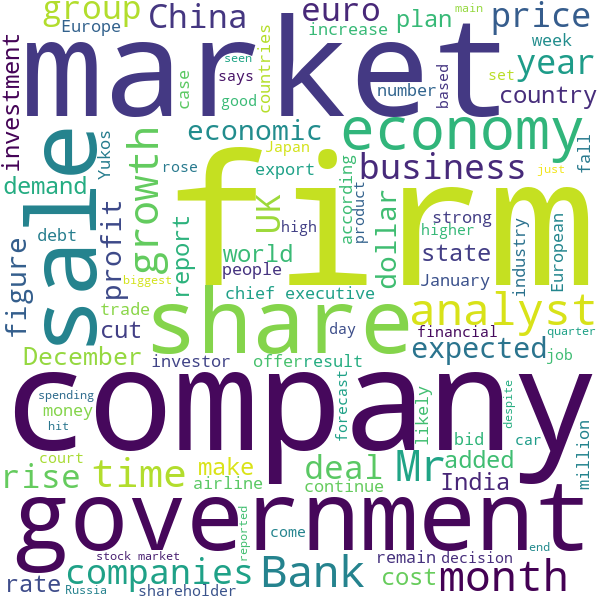

In [5]:
myAdditionalStopWords = ['say','said', 'new', 'need', 'year']
stopWords = ENGLISH_STOP_WORDS
stopWords = (stopWords.union(myAdditionalStopWords)).union(ENGLISH_STOP_WORDS)
makeWordCloud(saveLocationPath="businessWordCloud.png", myText=columnToText(myDataSetDf[myDataSetDf['CATEGORY'] == "BUSINESS"]['CONTENT']), myStopWords=stopWords)

Image('businessWordCloud.png')

- ### *Entertainment Wordcloud*

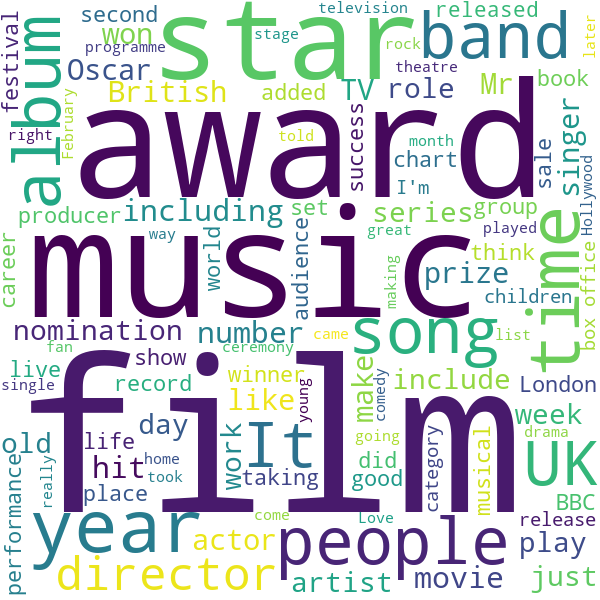

In [6]:

myAdditionalStopWords = ['say','said', 'new', 'need', 'year']
stopWords = ENGLISH_STOP_WORDS
stopWords = (stopWords.union(myAdditionalStopWords)).union(ENGLISH_STOP_WORDS)
makeWordCloud(saveLocationPath="entertainmentWordCloud.png", myText=columnToText(myDataSetDf[myDataSetDf['CATEGORY'] == "ENTERTAINMENT"]['CONTENT']), myStopWords=stopWords)

Image('entertainmentWordCloud.png')


- ### *Politics Wordcloud*

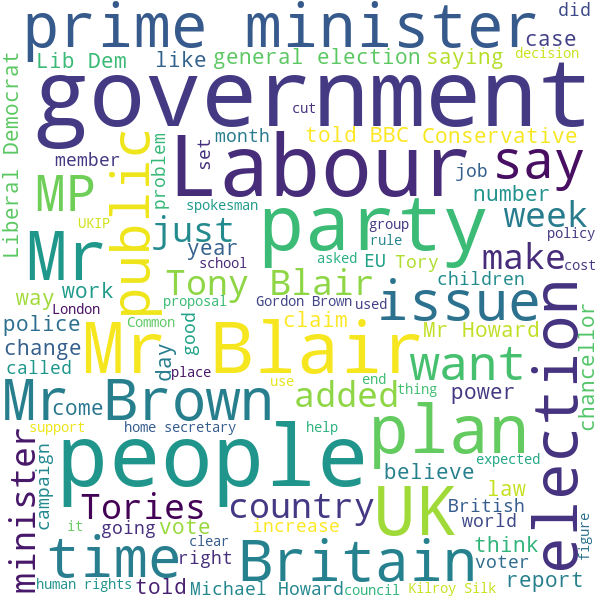

In [7]:

myAdditionalStopWords = ['say','said', 'new', 'need', 'year']
stopWords = ENGLISH_STOP_WORDS
stopWords = (stopWords.union(myAdditionalStopWords)).union(ENGLISH_STOP_WORDS)
makeWordCloud(saveLocationPath="politicsWordCloud.png", myText=columnToText(myDataSetDf[myDataSetDf['CATEGORY'] == "POLITICS"]['CONTENT']), myStopWords=stopWords)

Image('politicsWordCloud.png')


- ### *Sport Wordcloud*

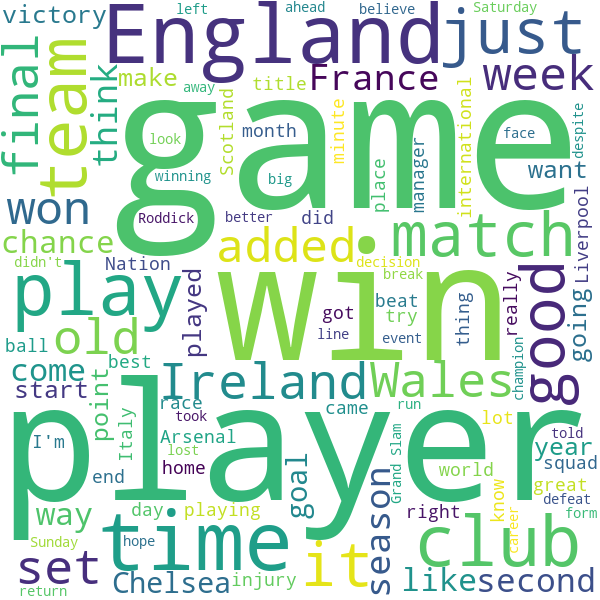

In [8]:

myAdditionalStopWords = ['say','said', 'new', 'need', 'year']
stopWords = ENGLISH_STOP_WORDS
stopWords = (stopWords.union(myAdditionalStopWords)).union(ENGLISH_STOP_WORDS)
makeWordCloud(saveLocationPath="sportWordCloud.png", myText=columnToText(myDataSetDf[myDataSetDf['CATEGORY'] == "SPORT"]['CONTENT']), myStopWords=stopWords)

Image('sportWordCloud.png')


- ### *Tech Wordcloud*

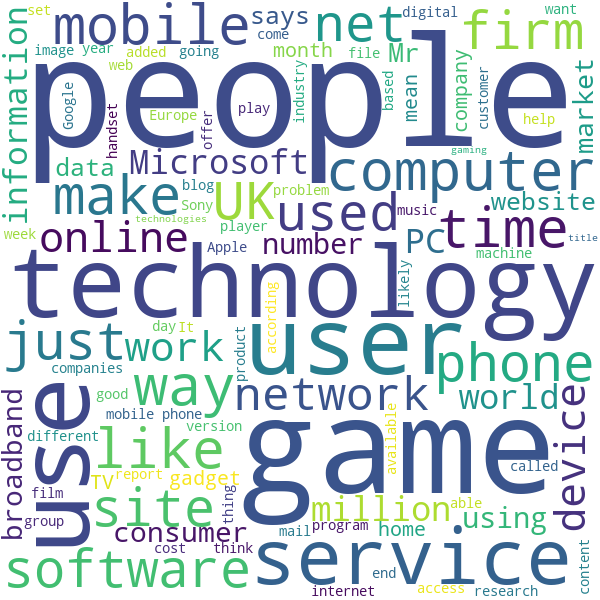

In [9]:

myAdditionalStopWords = ['say','said', 'new', 'need', 'year']
stopWords = ENGLISH_STOP_WORDS
stopWords = (stopWords.union(myAdditionalStopWords)).union(ENGLISH_STOP_WORDS)
makeWordCloud(saveLocationPath="techWordCloud.png", myText=columnToText(myDataSetDf[myDataSetDf['CATEGORY'] == "TECH"]['CONTENT']), myStopWords=stopWords)

Image('techWordCloud.png')


## __Classification__

  - #### Classification using SVM classifier

In [10]:
def SvmClassification(trainX, trainY, testX, testY, labelEncoder):
    """
    Classify the text using the SVM classifier of scikit-learn    
    """
    
    clf = svm.SVC(kernel='linear', C=1, probability=True)

    # fit train set
    clf.fit(trainX, trainY)
    
    # use 10-fold Cross Validation

    print('----Report for 10-fold Cross Validation----')

    # skf = StratifiedKFold(n_splits=10)
    # precisions = cross_val_score(clf, trainX, trainY, cv=skf, scoring='precision_weighted')

    precisions = cross_val_score(clf, trainX, trainY, cv=10, scoring='precision_weighted')
    print ('Precision ', np.mean(precisions))

    recalls = cross_val_score(clf, trainX, trainY, cv=10, scoring='recall_weighted')
    print ('Recalls ', np.mean(recalls))

    f1s = cross_val_score(clf, trainX, trainY, cv=10, scoring='f1_weighted')
    print ('F-Measure ', np.mean(f1s))

    scores = cross_val_score(clf, trainX, trainY, cv=10)
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

    # Predict test set
    predY = clf.predict(testX)

    # Classification_report
    print('----Report for predictions on test dataset----')
    print(classification_report(testY, predY, target_names=list(labelEncoder.classes_)))

    print('----ROC plot for predictions on test dataset----')
    return accuracy_score(testY, predY)

  - #### Classification using Random Forests classifier

In [11]:

# to fill


  - #### Classification using Naive Bayes classifier

In [12]:

# to fill


  - #### Classification using K-Nearest Neighbor classifier

In [13]:

# to fill


- ### *Split DataSet into TrainData and TestData*

In [14]:
trainDataSet, testDataSet = train_test_split(myDataSetDf, test_size=0.2, stratify=myDataSetDf['CATEGORY'])

# reset index
trainDataSet.reset_index(drop=True, inplace=True)
testDataSet.reset_index(drop=True, inplace=True)

# save to tsv files
trainDataSet.to_csv('train_set.tsv', sep = '\t')

# save test_set categories
testDataSetCategories = testDataSet[['CATEGORY']].copy()

testDataSetCategories.to_csv('test_set_categories.tsv', sep = '\t')

testDataSet = testDataSet.drop('CATEGORY', axis=1)
testDataSet.to_csv('test_set.tsv', sep = '\t')

Prepare train and test data that we will need below

In [15]:
# build label encoder for categories
le = preprocessing.LabelEncoder()
le.fit(trainDataSet["CATEGORY"])

# transform categories into numbers
trainY = le.transform(trainDataSet["CATEGORY"])
testY = le.transform(testDataSetCategories["CATEGORY"])

accuracyDict = dict()

## __Vectorization__

Let's do classification using 2 different ways of vectorization

  - #### Bag-of-words vectorization

In [16]:
bowVectorizer = CountVectorizer(max_features=1000)

trainX = bowVectorizer.fit_transform(trainDataSet['CONTENT'])
testX = bowVectorizer.transform(testDataSet['CONTENT'])

print('-------------SVM Classification with BOW Vectorization-------------')
accuracyDict["BOW-SVM"] = SvmClassification(trainX, trainY, testX, testY, le)
#accuracyDict["BOW-SVM"] = SvmClassification(trainX, trainY, trainX, trainY, le)

-------------SVM Classification with BOW Vectorization-------------
----Report for 10-fold Cross Validation----
Precision  0.9507586293875182
Recalls  0.9494064622611565
F-Measure  0.9494466468513301
Accuracy: 0.95 (+/- 0.02)
----Report for predictions on test dataset----
               precision    recall  f1-score   support

     BUSINESS       0.94      0.91      0.93       102
ENTERTAINMENT       0.89      0.91      0.90        77
     POLITICS       0.90      0.88      0.89        84
        SPORT       0.97      0.98      0.98       102
         TECH       0.94      0.96      0.95        80

     accuracy                           0.93       445
    macro avg       0.93      0.93      0.93       445
 weighted avg       0.93      0.93      0.93       445

----ROC plot for predictions on test dataset----


  - #### Tf-idf vectorization

In [17]:
tfIdfVectorizer = TfidfVectorizer(max_features=1000)

trainX = tfIdfVectorizer.fit_transform(trainDataSet['CONTENT'])
testX = tfIdfVectorizer.transform(testDataSet['CONTENT'])

print('-------------SVM Classification with TfIdf Vectorization-------------')
accuracyDict["TfIdf-SVM"] = SvmClassification(trainX, trainY, testX, testY, le)

-------------SVM Classification with TfIdf Vectorization-------------
----Report for 10-fold Cross Validation----
Precision  0.9704974581382194
Recalls  0.9696407033580904
F-Measure  0.9696655520723239
Accuracy: 0.97 (+/- 0.02)
----Report for predictions on test dataset----
               precision    recall  f1-score   support

     BUSINESS       0.94      0.95      0.95       102
ENTERTAINMENT       0.96      0.94      0.95        77
     POLITICS       0.93      0.92      0.92        84
        SPORT       0.99      1.00      1.00       102
         TECH       0.96      0.97      0.97        80

     accuracy                           0.96       445
    macro avg       0.96      0.96      0.96       445
 weighted avg       0.96      0.96      0.96       445

----ROC plot for predictions on test dataset----
